In [25]:
# 패션 MNIST 데이터 
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='.', train=True, download=True)
fm_test = FashionMNIST(root='.', train=False, download=True)

In [26]:
train_input = fm_train.data
train_target = fm_train.targets

test_input = fm_test.data
test_target = fm_test.targets

In [27]:
# (배치, 채널, 높이, 너비)

train_input = train_input.reshape(-1, 1, 28, 28)
test_input = test_input.reshape(-1, 1, 28, 28)

In [28]:
# 정규화 0 ~ 1
train_scaled = train_input / 255.0
test_scaled = test_input / 255.0

In [29]:
# 훈련세트, 검증세트 
from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [30]:
# 층을 구성 
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(1, 32, kernel_size=3, padding='same'))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(2))
model.add_module('conv2', nn.Conv2d(32, 64, kernel_size=3, padding='same'))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(2))
model.add_module('flatten', nn.Flatten())

In [31]:
import torch
outputs = model(torch.ones(1, 1, 28, 28))
outputs.shape

torch.Size([1, 3136])

In [32]:
model.add_module('dense1', nn.Linear(3136, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(0.3))
model.add_module('dense2', nn.Linear(100, 10))

In [33]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            320
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            313,700
├─ReLU: 1-9                              --
├─Dropout: 1-10                          --
├─Linear: 1-11                           1,010
Total params: 333,526
Trainable params: 333,526
Non-trainable params: 0

In [34]:
# GPU 또는 CPU를 model 연결 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=3136, out_features=100, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (dense2): Linear(in_features=100, out_features=10, bias=True)
)

In [35]:
# 옵티마이저, 손실함수 
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [36]:
# TensorDataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_scaled, train_target)
val_dataset = TensorDataset(val_scaled, val_target)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [37]:
# 훈련
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs=20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"에포크:{epoch+1}, 훈련손실:{train_loss:.4f}, 검증손실:{val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_cnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료")
            break

에포크:1, 훈련손실:0.5197, 검증손실:0.3526
에포크:2, 훈련손실:0.3412, 검증손실:0.3073
에포크:3, 훈련손실:0.2904, 검증손실:0.2528
에포크:4, 훈련손실:0.2596, 검증손실:0.2469
에포크:5, 훈련손실:0.2303, 검증손실:0.2330
에포크:6, 훈련손실:0.2106, 검증손실:0.2465
에포크:7, 훈련손실:0.1916, 검증손실:0.2182
에포크:8, 훈련손실:0.1755, 검증손실:0.2273
에포크:9, 훈련손실:0.1624, 검증손실:0.2335
9번째 에포크에서 조기 종료


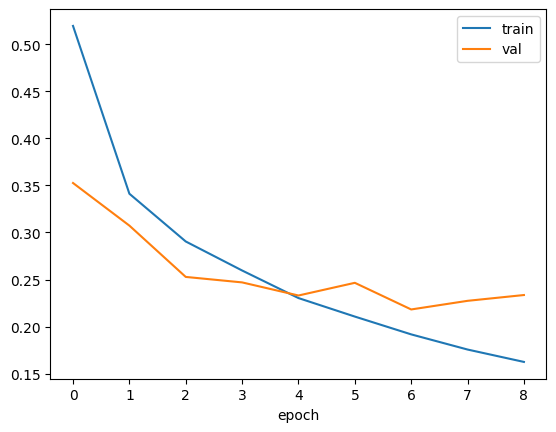

In [38]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [39]:
# 모델 가중치 불러오기 
model.load_state_dict(torch.load('best_cnn_model.pt',  weights_only=True))

<All keys matched successfully>

In [40]:
# 검증 세트의 loss(손실값), accuracy(정확도)
model.eval()
corrects = 0
val_loss = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = torch.argmax(outputs, 1)
        corrects += (predicts == targets).sum().item()

        loss = criterion(outputs, targets)
        val_loss += loss.item()

accuracy = corrects / len(val_dataset)
val_loss = val_loss /len(val_loader)
print(f"검증 정확도:{accuracy:.4f}, 검증 손실: {val_loss:.4f}")

검증 정확도:0.9180, 검증 손실: 0.2182
